In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import atecml.data

from contextlib import contextmanager
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegressionCV
#build Models...
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE, ADASYN
import random

plt.style.use('ggplot')

In [2]:
train_df = pd.read_pickle('./01_train.dat')


In [3]:
#unknown_idx = list(train_df[train_df.label == -1].index)
#train_df.loc[unknown_idx,'Fraud'] =1

In [4]:
#Fold
foo = atecml.data.load_train()

predictors = [x for x in foo.columns if x not in atecml.data.NOT_FEATURE_COLUMNS2]
predictors.append('mean')
DateFold={}

DateFold[0] = set(atecml.data.filter_date(train_df,start_date='2017-09-05',end_date='2017-09-13').index)
DateFold[1] = set(atecml.data.filter_date(train_df,start_date='2017-09-14',end_date='2017-09-22').index)
DateFold[2] = set(atecml.data.filter_date(train_df,start_date='2017-09-23',end_date='2017-10-01').index)
DateFold[3] = set(atecml.data.filter_date(train_df,start_date='2017-10-02',end_date='2017-10-12').index)
DateFold[4] = set(atecml.data.filter_date(train_df,start_date='2017-10-13',end_date='2017-10-22').index)
DateFold[5] = list(atecml.data.filter_date(train_df,start_date='2017-10-23',end_date='2017-11-24').index)

all_list = set(train_df.index) - set(DateFold[5])
len(all_list),len(DateFold[5])

(765667, 229064)

In [22]:
#将WOE mean作为信用分，进行分组，这里有测试集的leakage，根据测试集分组的， 因为各个WOE mean的权重不同

WOE_RANGE =[]
WOE_RANGE.append({ 'low': -1000, 'high': -0.75 })
WOE_RANGE.append({ 'low': -0.75, 'high': -0.5 })
WOE_RANGE.append({ 'low': -0.5, 'high': -0.2 })
WOE_RANGE.append({ 'low': -0.2, 'high': 0.2 })
WOE_RANGE.append({ 'low': 0.2, 'high': 0.5 })
WOE_RANGE.append({ 'low': 0.5, 'high': 1000 })

'''
WOE_RANGE =[]
WOE_RANGE.append({ 'low': -1000, 'high': -0.75 })
WOE_RANGE.append({ 'low': -0.75, 'high': 4000 })
'''

"\nWOE_RANGE =[]\nWOE_RANGE.append({ 'low': -1000, 'high': -0.75 })\nWOE_RANGE.append({ 'low': -0.75, 'high': 4000 })\n"

In [23]:
len(WOE_RANGE)

6

In [24]:
WOE_LIST = joblib.load('./woe_feature.dat')
CATE_LIST = WOE_LIST + atecml.data.CATE_FEATURE_LIST

categorical=[]
for item in predictors:
    if (item in CATE_LIST):
        categorical.append(item)

In [25]:
num_boosting_round = 1000
early_stop_round = 200

In [28]:
params = {
    
    'objective': 'binary',
    'metric': 'auc',
    'use_missing' : True,
    'is_unbalance': True,
    #'scale_pos_weight': 98,
    'learning_rate': 0.05,
    'num_leaves': 80,  # we should let it be smaller than 2^(max_depth)
    'max_depth': -1,  # -1 means no limit
    'min_child_samples': 5,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 255,  # Number of bucketed bin for feature values
    'colsample_bytree': 0.7,
    'subsample': 0.85,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0.01,  # L1 regularization term on weights
    'reg_lambda': 0.1,  # L2 regularization term on weights
    'nthread': 40,
    'n_estimators': num_boosting_round,
    'verbose': -1,
}

rf = {
    'boosting_type': 'rf',
}
rf.update(params)

dart = {
    'boosting_type': 'dart',
}
dart.update(params)

gbdt = {
    'boosting_type': 'gbdt',
}
gbdt.update(params)

param_list = [gbdt,dart]

In [29]:
sum_model_list = []
for woe_idx in range(0,len(WOE_RANGE)):
    model_list  =[]
    for idxn in tqdm(range(0,15)):
        idx = idxn//3
        woe_low =WOE_RANGE[woe_idx]['low']
        woe_high=WOE_RANGE[woe_idx]['high']
        t___df = train_df[train_df.index.isin(list(all_list - DateFold[idx]))].reset_index(drop=True)
        v___df = train_df[train_df.index.isin(DateFold[idx])].reset_index(drop=True)
        
        Train_DataSet = t___df[(t___df['mean'] > woe_low ) & (t___df['mean'] <= woe_high)].reset_index(drop=True)
        Val_DataSet   = v___df[(v___df['mean'] > woe_low ) & (v___df['mean'] <= woe_high)].reset_index(drop=True)
        
        Normal_DF = Train_DataSet[Train_DataSet['label']==0]
        Fraud_DF = Train_DataSet[Train_DataSet['label']==1]
        
        number_record_fraud = len(Fraud_DF)
        number_record_normal = len(Normal_DF)
        #undersample
        '''
        random_normal_indices = np.array(np.random.choice(Normal_DF.index,number_record_fraud,replace=False))
        filter_list = list(random_normal_indices) + list(Fraud_DF.index)
        under_sample_train = Train_DataSet[Train_DataSet.index.isin(filter_list)].reset_index(drop=True)
        X_train = under_sample_train[predictors]
        y_train = under_sample_train['Fraud']
        '''
        
        #oversample
        over_sample_rate = 2
        num_normal_required = number_record_fraud * over_sample_rate *7
        
        Normal_random_indices =  list(np.array(np.random.choice(Normal_DF.index,num_normal_required,replace=True)))
        Normal_random_df = Normal_DF[Normal_DF.index.isin(Normal_random_indices)]
        
        fraud_oversample_list =[Normal_random_df]
        for _idx in range(0,over_sample_rate):
            fraud_oversample_list.append(Fraud_DF)
        oversample_train = pd.concat(fraud_oversample_list,axis=0,ignore_index=True)  
        X_train = oversample_train[predictors]
        y_train = oversample_train['Fraud']
                
               

        X_test = Val_DataSet[predictors]
        y_test = Val_DataSet['Fraud']
        print(number_record_fraud,number_record_normal, len(X_train),len(X_test))
        
        for item_params in (param_list):
            gbm = lgb.LGBMClassifier(**item_params)
            print('starting fit model...')
            gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)],eval_metric='auc',early_stopping_rounds=early_stop_round,verbose=200)#,categorical_feature=categorical)
            model_list.append(gbm)  
        
    
    sum_model_list.append(model_list)


  0%|          | 0/15 [00:00<?, ?it/s]

3535 79309 43830 22791
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.950791
[400]	valid_0's auc: 0.950959
Early stopping, best iteration is:
[296]	valid_0's auc: 0.951347
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.94607
[400]	valid_0's auc: 0.949088
[600]	valid_0's auc: 0.950202



  7%|▋         | 1/15 [00:41<09:42, 41.60s/it]

Early stopping, best iteration is:
[566]	valid_0's auc: 0.950383
3535 79309 43989 22791
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.950164
[400]	valid_0's auc: 0.949957
[600]	valid_0's auc: 0.950392
[800]	valid_0's auc: 0.950583
[1000]	valid_0's auc: 0.950541
Did not meet early stopping. Best iteration is:
[903]	valid_0's auc: 0.950722
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.947376
[400]	valid_0's auc: 0.94946
[600]	valid_0's auc: 0.950063
[800]	valid_0's auc: 0.950314



 13%|█▎        | 2/15 [01:39<10:49, 49.94s/it]

[1000]	valid_0's auc: 0.950827
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.950829
3535 79309 43986 22791
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.948983
[400]	valid_0's auc: 0.948411
Early stopping, best iteration is:
[203]	valid_0's auc: 0.949004
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.946677
[400]	valid_0's auc: 0.947753
[600]	valid_0's auc: 0.948798



 20%|██        | 3/15 [02:17<09:11, 45.97s/it]

Early stopping, best iteration is:
[545]	valid_0's auc: 0.949269
3381 84128 42900 18090
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.947554
Early stopping, best iteration is:
[152]	valid_0's auc: 0.94817
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.94732
[400]	valid_0's auc: 0.94979
[600]	valid_0's auc: 0.950087



 27%|██▋       | 4/15 [02:53<07:57, 43.37s/it]

Early stopping, best iteration is:
[547]	valid_0's auc: 0.950266
3381 84128 43020 18090
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.94833
Early stopping, best iteration is:
[158]	valid_0's auc: 0.949011
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.947988
[400]	valid_0's auc: 0.94957
[600]	valid_0's auc: 0.949765



 33%|███▎      | 5/15 [03:28<06:56, 41.68s/it]

Early stopping, best iteration is:
[527]	valid_0's auc: 0.950051
3381 84128 42882 18090
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.946543
Early stopping, best iteration is:
[147]	valid_0's auc: 0.946938
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.947158
[400]	valid_0's auc: 0.94891



 40%|████      | 6/15 [03:58<05:58, 39.83s/it]

Early stopping, best iteration is:
[387]	valid_0's auc: 0.949116
2898 85774 38073 16918
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.948975
Early stopping, best iteration is:
[80]	valid_0's auc: 0.953994
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.953288



 47%|████▋     | 7/15 [04:20<04:57, 37.19s/it]

Early stopping, best iteration is:
[187]	valid_0's auc: 0.954125
2898 85774 38133 16918
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.948755
Early stopping, best iteration is:
[71]	valid_0's auc: 0.954966
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.954493
[400]	valid_0's auc: 0.954807



 53%|█████▎    | 8/15 [04:45<04:10, 35.73s/it]

Early stopping, best iteration is:
[323]	valid_0's auc: 0.955327
2898 85774 38083 16918
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.948266
Early stopping, best iteration is:
[47]	valid_0's auc: 0.95446
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.954226
[400]	valid_0's auc: 0.953662



 60%|██████    | 9/15 [05:09<03:26, 34.39s/it]

Early stopping, best iteration is:
[262]	valid_0's auc: 0.955567
3273 76314 40975 26034
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.959794
Early stopping, best iteration is:
[109]	valid_0's auc: 0.961914
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.960504
[400]	valid_0's auc: 0.96206
[600]	valid_0's auc: 0.962716



 67%|██████▋   | 10/15 [05:43<02:51, 34.37s/it]

Early stopping, best iteration is:
[458]	valid_0's auc: 0.963521
3273 76314 40894 26034
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.961746
[400]	valid_0's auc: 0.963348
[600]	valid_0's auc: 0.964345
[800]	valid_0's auc: 0.965348
[1000]	valid_0's auc: 0.965797
Did not meet early stopping. Best iteration is:
[974]	valid_0's auc: 0.965922
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.962714
[400]	valid_0's auc: 0.964385
[600]	valid_0's auc: 0.964996
[800]	valid_0's auc: 0.963566



 73%|███████▎  | 11/15 [06:35<02:23, 35.95s/it]

Early stopping, best iteration is:
[623]	valid_0's auc: 0.965271
3273 76314 40969 26034
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.961051
Early stopping, best iteration is:
[126]	valid_0's auc: 0.962402
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.962657
[400]	valid_0's auc: 0.964715



 80%|████████  | 12/15 [07:07<01:46, 35.65s/it]

Early stopping, best iteration is:
[386]	valid_0's auc: 0.965088
3485 79359 43463 22783
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.935597
[400]	valid_0's auc: 0.936911
[600]	valid_0's auc: 0.937321
Early stopping, best iteration is:
[469]	valid_0's auc: 0.937675
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.929858
[400]	valid_0's auc: 0.935372
[600]	valid_0's auc: 0.934926



 87%|████████▋ | 13/15 [07:48<01:12, 36.01s/it]

Early stopping, best iteration is:
[519]	valid_0's auc: 0.936263
3485 79359 43574 22783
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.934576
[400]	valid_0's auc: 0.935873
[600]	valid_0's auc: 0.936949
[800]	valid_0's auc: 0.937391
[1000]	valid_0's auc: 0.938786
Did not meet early stopping. Best iteration is:
[931]	valid_0's auc: 0.938827
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.930714
[400]	valid_0's auc: 0.933375



 93%|█████████▎| 14/15 [08:25<00:36, 36.13s/it]

Early stopping, best iteration is:
[289]	valid_0's auc: 0.935105
3485 79359 43410 22783
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.935745
[400]	valid_0's auc: 0.937231
[600]	valid_0's auc: 0.938772
[800]	valid_0's auc: 0.939824
[1000]	valid_0's auc: 0.939201
Did not meet early stopping. Best iteration is:
[885]	valid_0's auc: 0.940004
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.930691
[400]	valid_0's auc: 0.935476
[600]	valid_0's auc: 0.936161



100%|██████████| 15/15 [09:12<00:00, 36.85s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Early stopping, best iteration is:
[548]	valid_0's auc: 0.937119
133 129 395 7
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 1
Early stopping, best iteration is:
[15]	valid_0's auc: 1
starting fit model...
Training until validation scores don't improve for 200 rounds.



  7%|▋         | 1/15 [00:05<01:16,  5.46s/it]

[200]	valid_0's auc: 1
Early stopping, best iteration is:
[15]	valid_0's auc: 1
133 129 395 7
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 1
Early stopping, best iteration is:
[15]	valid_0's auc: 1
starting fit model...
Training until validation scores don't improve for 200 rounds.



 13%|█▎        | 2/15 [00:10<01:10,  5.44s/it]

[200]	valid_0's auc: 1
Early stopping, best iteration is:
[15]	valid_0's auc: 1
133 129 395 7
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 1
Early stopping, best iteration is:
[15]	valid_0's auc: 1
starting fit model...
Training until validation scores don't improve for 200 rounds.



 20%|██        | 3/15 [00:16<01:04,  5.38s/it]

[200]	valid_0's auc: 1
Early stopping, best iteration is:
[15]	valid_0's auc: 1
107 85 299 78
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.612857
Early stopping, best iteration is:
[63]	valid_0's auc: 0.632143
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.637143
[400]	valid_0's auc: 0.65
[600]	valid_0's auc: 0.653571



 27%|██▋       | 4/15 [00:23<01:03,  5.76s/it]

Early stopping, best iteration is:
[590]	valid_0's auc: 0.656429
107 85 299 78
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.612857
Early stopping, best iteration is:
[63]	valid_0's auc: 0.632143
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.637143
[400]	valid_0's auc: 0.65
[600]	valid_0's auc: 0.653571



 33%|███▎      | 5/15 [00:30<01:00,  6.04s/it]

Early stopping, best iteration is:
[590]	valid_0's auc: 0.656429
107 85 299 78
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.612857
Early stopping, best iteration is:
[63]	valid_0's auc: 0.632143
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.637143
[400]	valid_0's auc: 0.65
[600]	valid_0's auc: 0.653571



 40%|████      | 6/15 [00:37<00:56,  6.23s/it]

Early stopping, best iteration is:
[590]	valid_0's auc: 0.656429
119 103 341 53
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518581
Early stopping, best iteration is:
[2]	valid_0's auc: 0.865709
starting fit model...
Training until validation scores don't improve for 200 rounds.



 47%|████▋     | 7/15 [00:42<00:48,  6.08s/it]

[200]	valid_0's auc: 0.603041
Early stopping, best iteration is:
[2]	valid_0's auc: 0.865709
119 103 341 53
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518581
Early stopping, best iteration is:
[2]	valid_0's auc: 0.865709
starting fit model...
Training until validation scores don't improve for 200 rounds.



 53%|█████▎    | 8/15 [00:46<00:41,  5.87s/it]

[200]	valid_0's auc: 0.603041
Early stopping, best iteration is:
[2]	valid_0's auc: 0.865709
119 103 341 53
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518581
Early stopping, best iteration is:
[2]	valid_0's auc: 0.865709
starting fit model...
Training until validation scores don't improve for 200 rounds.



 60%|██████    | 9/15 [00:51<00:34,  5.76s/it]

[200]	valid_0's auc: 0.603041
Early stopping, best iteration is:
[2]	valid_0's auc: 0.865709
118 106 342 47
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.696078
Early stopping, best iteration is:
[9]	valid_0's auc: 0.8
starting fit model...
Training until validation scores don't improve for 200 rounds.



 67%|██████▋   | 10/15 [00:56<00:28,  5.68s/it]

[200]	valid_0's auc: 0.711765
Early stopping, best iteration is:
[11]	valid_0's auc: 0.810784
118 106 342 47
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.696078
Early stopping, best iteration is:
[9]	valid_0's auc: 0.8
starting fit model...
Training until validation scores don't improve for 200 rounds.



 73%|███████▎  | 11/15 [01:01<00:22,  5.63s/it]

[200]	valid_0's auc: 0.711765
Early stopping, best iteration is:
[11]	valid_0's auc: 0.810784
118 106 342 47
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.696078
Early stopping, best iteration is:
[9]	valid_0's auc: 0.8
starting fit model...
Training until validation scores don't improve for 200 rounds.



 80%|████████  | 12/15 [01:07<00:16,  5.60s/it]

[200]	valid_0's auc: 0.711765
Early stopping, best iteration is:
[11]	valid_0's auc: 0.810784
63 109 235 100
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.344742
Early stopping, best iteration is:
[2]	valid_0's auc: 0.564484
starting fit model...
Training until validation scores don't improve for 200 rounds.



 87%|████████▋ | 13/15 [01:11<00:10,  5.50s/it]

[200]	valid_0's auc: 0.354663
Early stopping, best iteration is:
[2]	valid_0's auc: 0.564484
63 109 235 100
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.344742
Early stopping, best iteration is:
[2]	valid_0's auc: 0.564484
starting fit model...
Training until validation scores don't improve for 200 rounds.



 93%|█████████▎| 14/15 [01:16<00:05,  5.45s/it]

[200]	valid_0's auc: 0.354663
Early stopping, best iteration is:
[2]	valid_0's auc: 0.564484
63 109 235 100
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.344742
Early stopping, best iteration is:
[2]	valid_0's auc: 0.564484
starting fit model...
Training until validation scores don't improve for 200 rounds.



100%|██████████| 15/15 [01:20<00:00,  5.37s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

[200]	valid_0's auc: 0.354663
Early stopping, best iteration is:
[2]	valid_0's auc: 0.564484
773 2227 3753 291
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.778506
[400]	valid_0's auc: 0.787552
[600]	valid_0's auc: 0.792116
[800]	valid_0's auc: 0.792282
Early stopping, best iteration is:
[751]	valid_0's auc: 0.792946
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.748465
[400]	valid_0's auc: 0.794689
[600]	valid_0's auc: 0.805726
[800]	valid_0's auc: 0.814523



  7%|▋         | 1/15 [00:33<07:48, 33.47s/it]

[1000]	valid_0's auc: 0.827303
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.827386
773 2227 3755 291
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.823402
[400]	valid_0's auc: 0.832365
Early stopping, best iteration is:
[373]	valid_0's auc: 0.83444
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.740664
[400]	valid_0's auc: 0.790456
[600]	valid_0's auc: 0.799087
[800]	valid_0's auc: 0.810788



 13%|█▎        | 2/15 [01:03<06:55, 31.95s/it]

[1000]	valid_0's auc: 0.815021
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.815519
773 2227 3756 291
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.800249
[400]	valid_0's auc: 0.815353
[600]	valid_0's auc: 0.815851
Early stopping, best iteration is:
[567]	valid_0's auc: 0.817427
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.783402
[400]	valid_0's auc: 0.805975
[600]	valid_0's auc: 0.826722



 20%|██        | 3/15 [01:31<06:04, 30.40s/it]

Early stopping, best iteration is:
[580]	valid_0's auc: 0.830207
707 2063 3469 561
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.749361
Early stopping, best iteration is:
[59]	valid_0's auc: 0.771426
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.743956



 27%|██▋       | 4/15 [01:42<04:41, 25.62s/it]

Early stopping, best iteration is:
[48]	valid_0's auc: 0.771077
707 2063 3457 561
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.74659
Early stopping, best iteration is:
[84]	valid_0's auc: 0.758408
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.754552



 33%|███▎      | 5/15 [01:56<03:52, 23.21s/it]

Early stopping, best iteration is:
[133]	valid_0's auc: 0.775901
707 2063 3464 561
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.733301
Early stopping, best iteration is:
[84]	valid_0's auc: 0.744924
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.748508



 40%|████      | 6/15 [02:08<03:12, 21.40s/it]

Early stopping, best iteration is:
[86]	valid_0's auc: 0.760849
653 1865 3154 810
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.739329
[400]	valid_0's auc: 0.734173
Early stopping, best iteration is:
[204]	valid_0's auc: 0.740818
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.736397



 47%|████▋     | 7/15 [02:23<02:43, 20.45s/it]

Early stopping, best iteration is:
[129]	valid_0's auc: 0.749669
653 1865 3162 810
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.733419
Early stopping, best iteration is:
[12]	valid_0's auc: 0.742422
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.734678



 53%|█████▎    | 8/15 [02:33<02:14, 19.20s/it]

Early stopping, best iteration is:
[52]	valid_0's auc: 0.747665
653 1865 3150 810
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.742509
Early stopping, best iteration is:
[31]	valid_0's auc: 0.756673
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.748051



 60%|██████    | 9/15 [02:47<01:51, 18.57s/it]

[400]	valid_0's auc: 0.736967
Early stopping, best iteration is:
[207]	valid_0's auc: 0.749347
531 1666 2700 1139
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.670198
[400]	valid_0's auc: 0.678426
[600]	valid_0's auc: 0.683626
[800]	valid_0's auc: 0.685963
[1000]	valid_0's auc: 0.687794
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.687806
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.669341
[400]	valid_0's auc: 0.684086
[600]	valid_0's auc: 0.685781
[800]	valid_0's auc: 0.686609



 67%|██████▋   | 10/15 [03:17<01:38, 19.79s/it]

[1000]	valid_0's auc: 0.690317
Did not meet early stopping. Best iteration is:
[887]	valid_0's auc: 0.6913
531 1666 2713 1139
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.661897
[400]	valid_0's auc: 0.671718
[600]	valid_0's auc: 0.676057
[800]	valid_0's auc: 0.678575
[1000]	valid_0's auc: 0.680221
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.680221
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.634932
[400]	valid_0's auc: 0.666923



 73%|███████▎  | 11/15 [03:41<01:20, 20.10s/it]

Early stopping, best iteration is:
[398]	valid_0's auc: 0.667764
531 1666 2710 1139
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.657094
Early stopping, best iteration is:
[1]	valid_0's auc: 0.687368
starting fit model...
Training until validation scores don't improve for 200 rounds.



 80%|████████  | 12/15 [03:51<00:57, 19.26s/it]

[200]	valid_0's auc: 0.651898
Early stopping, best iteration is:
[1]	valid_0's auc: 0.687368
628 1979 3212 701
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.687494
[400]	valid_0's auc: 0.690727
[600]	valid_0's auc: 0.688294
Early stopping, best iteration is:
[407]	valid_0's auc: 0.691152
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.673396
[400]	valid_0's auc: 0.681453



 87%|████████▋ | 13/15 [04:09<00:38, 19.22s/it]

Early stopping, best iteration is:
[267]	valid_0's auc: 0.683835
628 1979 3220 701
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.676062
[400]	valid_0's auc: 0.678747
Early stopping, best iteration is:
[284]	valid_0's auc: 0.6797
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.652103



 93%|█████████▎| 14/15 [04:23<00:18, 18.81s/it]

Early stopping, best iteration is:
[23]	valid_0's auc: 0.662638
628 1979 3211 701
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.671785
[400]	valid_0's auc: 0.676112
[600]	valid_0's auc: 0.677957
[800]	valid_0's auc: 0.678909
[1000]	valid_0's auc: 0.679406
Did not meet early stopping. Best iteration is:
[908]	valid_0's auc: 0.67969
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.660039
[400]	valid_0's auc: 0.672727
[600]	valid_0's auc: 0.674045



100%|██████████| 15/15 [04:48<00:00, 19.27s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Early stopping, best iteration is:
[480]	valid_0's auc: 0.677633
1754 17198 16587 5798
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.77202
[400]	valid_0's auc: 0.772461
[600]	valid_0's auc: 0.776675
Early stopping, best iteration is:
[559]	valid_0's auc: 0.777794
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.77308
[400]	valid_0's auc: 0.786248
[600]	valid_0's auc: 0.778291



  7%|▋         | 1/15 [00:35<08:14, 35.29s/it]

Early stopping, best iteration is:
[408]	valid_0's auc: 0.787085
1754 17198 16552 5798
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.771691
Early stopping, best iteration is:
[133]	valid_0's auc: 0.779179
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.763726



 13%|█▎        | 2/15 [00:55<06:00, 27.72s/it]

Early stopping, best iteration is:
[140]	valid_0's auc: 0.77194
1754 17198 16605 5798
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.77327
[400]	valid_0's auc: 0.774503
[600]	valid_0's auc: 0.776154
Early stopping, best iteration is:
[586]	valid_0's auc: 0.7772
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.764933



 20%|██        | 3/15 [01:20<05:22, 26.87s/it]

Early stopping, best iteration is:
[19]	valid_0's auc: 0.77071
1927 19186 18371 3609
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.808672
Early stopping, best iteration is:
[156]	valid_0's auc: 0.810658
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.814406
[400]	valid_0's auc: 0.818549
[600]	valid_0's auc: 0.819068



 27%|██▋       | 4/15 [01:51<05:07, 27.97s/it]

Early stopping, best iteration is:
[468]	valid_0's auc: 0.822109
1927 19186 18317 3609
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.80694
[400]	valid_0's auc: 0.809066
[600]	valid_0's auc: 0.810545
[800]	valid_0's auc: 0.812149
Early stopping, best iteration is:
[765]	valid_0's auc: 0.812997
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.812011



 33%|███▎      | 5/15 [02:27<04:54, 29.44s/it]

Early stopping, best iteration is:
[194]	valid_0's auc: 0.813188
1927 19186 18315 3609
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.821455
Early stopping, best iteration is:
[177]	valid_0's auc: 0.823117
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.819841



 40%|████      | 6/15 [02:49<04:14, 28.23s/it]

Early stopping, best iteration is:
[150]	valid_0's auc: 0.824067
1796 18548 17373 4373
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.801455
[400]	valid_0's auc: 0.806966
[600]	valid_0's auc: 0.811049
[800]	valid_0's auc: 0.812613
[1000]	valid_0's auc: 0.813768
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.813768
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.804968
[400]	valid_0's auc: 0.806152



 47%|████▋     | 7/15 [03:27<03:56, 29.57s/it]

Early stopping, best iteration is:
[297]	valid_0's auc: 0.80892
1796 18548 17407 4373
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.802343
Early stopping, best iteration is:
[163]	valid_0's auc: 0.804905
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.802149
[400]	valid_0's auc: 0.808661
[600]	valid_0's auc: 0.810703



 53%|█████▎    | 8/15 [03:57<03:28, 29.73s/it]

Early stopping, best iteration is:
[445]	valid_0's auc: 0.811126
1796 18548 17308 4373
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.801003
Early stopping, best iteration is:
[107]	valid_0's auc: 0.805645
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.806477
[400]	valid_0's auc: 0.815623



 60%|██████    | 9/15 [04:25<02:57, 29.52s/it]

Early stopping, best iteration is:
[397]	valid_0's auc: 0.816267
1582 16459 15339 6776
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.866867
[400]	valid_0's auc: 0.869339
[600]	valid_0's auc: 0.87077
[800]	valid_0's auc: 0.871986
[1000]	valid_0's auc: 0.873534
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.873546
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.851267
[400]	valid_0's auc: 0.858332
[600]	valid_0's auc: 0.860734
[800]	valid_0's auc: 0.863307



 67%|██████▋   | 10/15 [05:17<02:38, 31.77s/it]

[1000]	valid_0's auc: 0.865408
Did not meet early stopping. Best iteration is:
[969]	valid_0's auc: 0.86664
1582 16459 15334 6776
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.857958
[400]	valid_0's auc: 0.865898
[600]	valid_0's auc: 0.868581
[800]	valid_0's auc: 0.871099
[1000]	valid_0's auc: 0.87186
Did not meet early stopping. Best iteration is:
[992]	valid_0's auc: 0.87195
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.846786
[400]	valid_0's auc: 0.854571
[600]	valid_0's auc: 0.859046
[800]	valid_0's auc: 0.859826



 73%|███████▎  | 11/15 [06:11<02:15, 33.77s/it]

[1000]	valid_0's auc: 0.860903
Did not meet early stopping. Best iteration is:
[995]	valid_0's auc: 0.861396
1582 16459 15347 6776
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.855318
[400]	valid_0's auc: 0.857058
[600]	valid_0's auc: 0.862255
[800]	valid_0's auc: 0.865954
[1000]	valid_0's auc: 0.86788
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.867908
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.850611



 80%|████████  | 12/15 [06:41<01:40, 33.45s/it]

Early stopping, best iteration is:
[21]	valid_0's auc: 0.852187
1645 17853 16214 5254
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.82624
Early stopping, best iteration is:
[88]	valid_0's auc: 0.833138
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.833489
[400]	valid_0's auc: 0.834732
[600]	valid_0's auc: 0.835026



 87%|████████▋ | 13/15 [07:12<01:06, 33.23s/it]

Early stopping, best iteration is:
[476]	valid_0's auc: 0.839913
1645 17853 16285 5254
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.832493
Early stopping, best iteration is:
[141]	valid_0's auc: 0.836937
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.83583
[400]	valid_0's auc: 0.838669



 93%|█████████▎| 14/15 [07:38<00:32, 32.75s/it]

Early stopping, best iteration is:
[369]	valid_0's auc: 0.840577
1645 17853 16214 5254
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.829389
[400]	valid_0's auc: 0.831824
[600]	valid_0's auc: 0.832923
[800]	valid_0's auc: 0.833608
Early stopping, best iteration is:
[655]	valid_0's auc: 0.83423
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.837415
[400]	valid_0's auc: 0.838679



100%|██████████| 15/15 [08:13<00:00, 32.89s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Early stopping, best iteration is:
[308]	valid_0's auc: 0.840512
1062 106719 15962 72206
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.899579
[400]	valid_0's auc: 0.904597
[600]	valid_0's auc: 0.906595
[800]	valid_0's auc: 0.906563
Early stopping, best iteration is:
[622]	valid_0's auc: 0.906944
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.885978
[400]	valid_0's auc: 0.896071
[600]	valid_0's auc: 0.899108
[800]	valid_0's auc: 0.9005



  7%|▋         | 1/15 [01:11<16:43, 71.71s/it]

[1000]	valid_0's auc: 0.901171
Did not meet early stopping. Best iteration is:
[842]	valid_0's auc: 0.90164
1062 106719 15991 72206
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.913874
[400]	valid_0's auc: 0.919698
[600]	valid_0's auc: 0.920095
Early stopping, best iteration is:
[530]	valid_0's auc: 0.920264
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.902736
[400]	valid_0's auc: 0.911083
[600]	valid_0's auc: 0.913377
[800]	valid_0's auc: 0.913003



 13%|█▎        | 2/15 [02:21<15:18, 70.62s/it]

[1000]	valid_0's auc: 0.915076
Did not meet early stopping. Best iteration is:
[941]	valid_0's auc: 0.91573
1062 106719 16034 72206
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.899478
[400]	valid_0's auc: 0.904656
[600]	valid_0's auc: 0.906405
[800]	valid_0's auc: 0.907684
Early stopping, best iteration is:
[764]	valid_0's auc: 0.907883
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.900728
[400]	valid_0's auc: 0.904364
[600]	valid_0's auc: 0.907216
[800]	valid_0's auc: 0.909897



 20%|██        | 3/15 [03:32<14:10, 70.86s/it]

Early stopping, best iteration is:
[700]	valid_0's auc: 0.910487
1233 144073 18684 34644
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.9214
[400]	valid_0's auc: 0.925325
[600]	valid_0's auc: 0.925945
Early stopping, best iteration is:
[499]	valid_0's auc: 0.926751
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.909738
[400]	valid_0's auc: 0.92155
[600]	valid_0's auc: 0.926469
[800]	valid_0's auc: 0.930191



 27%|██▋       | 4/15 [04:30<12:25, 67.74s/it]

[1000]	valid_0's auc: 0.931539
Did not meet early stopping. Best iteration is:
[984]	valid_0's auc: 0.932041
1233 144073 18715 34644
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.921193
[400]	valid_0's auc: 0.923476
Early stopping, best iteration is:
[351]	valid_0's auc: 0.924078
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.909741
[400]	valid_0's auc: 0.922197
[600]	valid_0's auc: 0.92322



 33%|███▎      | 5/15 [05:14<10:29, 62.94s/it]

Early stopping, best iteration is:
[489]	valid_0's auc: 0.924744
1233 144073 18749 34644
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.923393
[400]	valid_0's auc: 0.931645
[600]	valid_0's auc: 0.93102
Early stopping, best iteration is:
[493]	valid_0's auc: 0.932014
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.917127
[400]	valid_0's auc: 0.925244
[600]	valid_0's auc: 0.926883
[800]	valid_0's auc: 0.927103



 40%|████      | 6/15 [06:07<09:11, 61.30s/it]

Early stopping, best iteration is:
[655]	valid_0's auc: 0.929212
1118 154937 17120 23873
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.892146
[400]	valid_0's auc: 0.886927
Early stopping, best iteration is:
[206]	valid_0's auc: 0.892758
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.875972
[400]	valid_0's auc: 0.886129



 47%|████▋     | 7/15 [06:41<07:38, 57.37s/it]

Early stopping, best iteration is:
[375]	valid_0's auc: 0.890121
1118 154937 17146 23873
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.87826
Early stopping, best iteration is:
[161]	valid_0's auc: 0.88227
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.891405



 53%|█████▎    | 8/15 [07:07<06:14, 53.45s/it]

Early stopping, best iteration is:
[173]	valid_0's auc: 0.892401
1118 154937 17131 23873
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.887812
Early stopping, best iteration is:
[114]	valid_0's auc: 0.890913
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.893787
[400]	valid_0's auc: 0.895379



 60%|██████    | 9/15 [07:34<05:03, 50.53s/it]

Early stopping, best iteration is:
[256]	valid_0's auc: 0.897529
1151 154302 17615 24520
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.937083
[400]	valid_0's auc: 0.937433
[600]	valid_0's auc: 0.937784
Early stopping, best iteration is:
[476]	valid_0's auc: 0.937982
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.93289
[400]	valid_0's auc: 0.937482
[600]	valid_0's auc: 0.938043



 67%|██████▋   | 10/15 [08:18<04:09, 49.87s/it]

Early stopping, best iteration is:
[486]	valid_0's auc: 0.940338
1151 154302 17602 24520
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.93211
[400]	valid_0's auc: 0.935412
[600]	valid_0's auc: 0.93699
[800]	valid_0's auc: 0.93779
[1000]	valid_0's auc: 0.937838
Did not meet early stopping. Best iteration is:
[890]	valid_0's auc: 0.938079
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.931256
[400]	valid_0's auc: 0.934313
[600]	valid_0's auc: 0.936963
[800]	valid_0's auc: 0.939314



 73%|███████▎  | 11/15 [09:20<03:23, 50.97s/it]

[1000]	valid_0's auc: 0.939074
Did not meet early stopping. Best iteration is:
[890]	valid_0's auc: 0.939938
1151 154302 17619 24520
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.938223
[400]	valid_0's auc: 0.939446
[600]	valid_0's auc: 0.93871
Early stopping, best iteration is:
[433]	valid_0's auc: 0.940276
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.930196
[400]	valid_0's auc: 0.939137
[600]	valid_0's auc: 0.938914



 80%|████████  | 12/15 [10:00<02:30, 50.02s/it]

Early stopping, best iteration is:
[414]	valid_0's auc: 0.939266
1160 153529 17692 25268
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.882601
[400]	valid_0's auc: 0.886419
Early stopping, best iteration is:
[360]	valid_0's auc: 0.888716
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.861179
[400]	valid_0's auc: 0.869405
[600]	valid_0's auc: 0.880167
[800]	valid_0's auc: 0.884497



 87%|████████▋ | 13/15 [10:52<01:40, 50.16s/it]

[1000]	valid_0's auc: 0.890004
Did not meet early stopping. Best iteration is:
[978]	valid_0's auc: 0.890591
1160 153529 17723 25268
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.878495
[400]	valid_0's auc: 0.885242
[600]	valid_0's auc: 0.883665
Early stopping, best iteration is:
[484]	valid_0's auc: 0.886355
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.856912
[400]	valid_0's auc: 0.867575
[600]	valid_0's auc: 0.876063
[800]	valid_0's auc: 0.879515



 93%|█████████▎| 14/15 [11:47<00:50, 50.57s/it]

[1000]	valid_0's auc: 0.882576
Did not meet early stopping. Best iteration is:
[996]	valid_0's auc: 0.882983
1160 153529 17683 25268
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.884618
[400]	valid_0's auc: 0.885552
Early stopping, best iteration is:
[298]	valid_0's auc: 0.887928
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.862828
[400]	valid_0's auc: 0.877281
[600]	valid_0's auc: 0.885598



100%|██████████| 15/15 [12:30<00:00, 50.03s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Early stopping, best iteration is:
[568]	valid_0's auc: 0.8871
315 400804 5021 47583
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.945604
[400]	valid_0's auc: 0.948824
[600]	valid_0's auc: 0.949123
[800]	valid_0's auc: 0.949395
[1000]	valid_0's auc: 0.949541
Did not meet early stopping. Best iteration is:
[991]	valid_0's auc: 0.94956
starting fit model...
Training until validation scores don't improve for 200 rounds.



  7%|▋         | 1/15 [00:24<05:45, 24.67s/it]

[200]	valid_0's auc: 0.937256
Early stopping, best iteration is:
[5]	valid_0's auc: 0.94502
315 400804 5013 47583
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.952414
[400]	valid_0's auc: 0.952673
[600]	valid_0's auc: 0.95232
Early stopping, best iteration is:
[402]	valid_0's auc: 0.952703
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.949225
[400]	valid_0's auc: 0.951743
[600]	valid_0's auc: 0.952387



 13%|█▎        | 2/15 [00:59<06:26, 29.72s/it]

Early stopping, best iteration is:
[542]	valid_0's auc: 0.952846
315 400804 5020 47583
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.947468
[400]	valid_0's auc: 0.949645
[600]	valid_0's auc: 0.950371
[800]	valid_0's auc: 0.950791
[1000]	valid_0's auc: 0.950855
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.950855
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.946347
[400]	valid_0's auc: 0.950372
[600]	valid_0's auc: 0.95285
[800]	valid_0's auc: 0.954075



 20%|██        | 3/15 [01:46<07:04, 35.40s/it]

[1000]	valid_0's auc: 0.954418
Did not meet early stopping. Best iteration is:
[910]	valid_0's auc: 0.954723
315 364205 5016 84180
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.926546
[400]	valid_0's auc: 0.926982
[600]	valid_0's auc: 0.927686
[800]	valid_0's auc: 0.928693
[1000]	valid_0's auc: 0.928686
Did not meet early stopping. Best iteration is:
[904]	valid_0's auc: 0.928969
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.896267
[400]	valid_0's auc: 0.919713
[600]	valid_0's auc: 0.927092
[800]	valid_0's auc: 0.931637



 27%|██▋       | 4/15 [02:44<07:33, 41.24s/it]

[1000]	valid_0's auc: 0.931527
Did not meet early stopping. Best iteration is:
[941]	valid_0's auc: 0.932658
315 364205 5017 84180
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.912705
[400]	valid_0's auc: 0.916264
[600]	valid_0's auc: 0.915046
Early stopping, best iteration is:
[410]	valid_0's auc: 0.916791
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.891294
[400]	valid_0's auc: 0.912745
[600]	valid_0's auc: 0.92054
[800]	valid_0's auc: 0.922981



 33%|███▎      | 5/15 [03:36<07:12, 43.23s/it]

Early stopping, best iteration is:
[735]	valid_0's auc: 0.925308
315 364205 5021 84180
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.925133
[400]	valid_0's auc: 0.931151
Early stopping, best iteration is:
[291]	valid_0's auc: 0.931824
starting fit model...
Training until validation scores don't improve for 200 rounds.



 40%|████      | 6/15 [03:59<05:59, 39.99s/it]

[200]	valid_0's auc: 0.90331
Early stopping, best iteration is:
[1]	valid_0's auc: 0.911459
310 353182 4933 95204
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.931814
Early stopping, best iteration is:
[181]	valid_0's auc: 0.93308
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.917351
[400]	valid_0's auc: 0.931871
[600]	valid_0's auc: 0.93479



 47%|████▋     | 7/15 [04:42<05:23, 40.42s/it]

Early stopping, best iteration is:
[529]	valid_0's auc: 0.935863
310 353182 4931 95204
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.933237
[400]	valid_0's auc: 0.933174
Early stopping, best iteration is:
[235]	valid_0's auc: 0.934601
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.914082
[400]	valid_0's auc: 0.934697
[600]	valid_0's auc: 0.938094



 53%|█████▎    | 8/15 [05:25<04:44, 40.66s/it]

Early stopping, best iteration is:
[508]	valid_0's auc: 0.939847
310 353182 4939 95204
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.935858
[400]	valid_0's auc: 0.935465
Early stopping, best iteration is:
[245]	valid_0's auc: 0.936717
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.925588
[400]	valid_0's auc: 0.936882
[600]	valid_0's auc: 0.938025



 60%|██████    | 9/15 [06:05<04:03, 40.66s/it]

Early stopping, best iteration is:
[464]	valid_0's auc: 0.940027
284 336013 4522 112436
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.942144
[400]	valid_0's auc: 0.947676
[600]	valid_0's auc: 0.94963
[800]	valid_0's auc: 0.950566
[1000]	valid_0's auc: 0.951168
Did not meet early stopping. Best iteration is:
[968]	valid_0's auc: 0.951217
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.935893
[400]	valid_0's auc: 0.936751



 67%|██████▋   | 10/15 [06:52<03:26, 41.27s/it]

Early stopping, best iteration is:
[247]	valid_0's auc: 0.938777
284 336013 4519 112436
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.946107
[400]	valid_0's auc: 0.951643
[600]	valid_0's auc: 0.953386
[800]	valid_0's auc: 0.954017
[1000]	valid_0's auc: 0.954372
Did not meet early stopping. Best iteration is:
[924]	valid_0's auc: 0.954442
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.927201



 73%|███████▎  | 11/15 [07:30<02:43, 40.93s/it]

Early stopping, best iteration is:
[17]	valid_0's auc: 0.933517
284 336013 4522 112436
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.944908
[400]	valid_0's auc: 0.949763
[600]	valid_0's auc: 0.951762
[800]	valid_0's auc: 0.952662
[1000]	valid_0's auc: 0.952567
Did not meet early stopping. Best iteration is:
[810]	valid_0's auc: 0.952692
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.93123



 80%|████████  | 12/15 [08:10<02:02, 40.91s/it]

Early stopping, best iteration is:
[72]	valid_0's auc: 0.935265
256 338920 4077 109540
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.916215
[400]	valid_0's auc: 0.917524
Early stopping, best iteration is:
[320]	valid_0's auc: 0.918878
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.915227
[400]	valid_0's auc: 0.927885



 87%|████████▋ | 13/15 [08:50<01:21, 40.80s/it]

Early stopping, best iteration is:
[359]	valid_0's auc: 0.929337
256 338920 4081 109540
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.909418
Early stopping, best iteration is:
[119]	valid_0's auc: 0.912403
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.909529
[400]	valid_0's auc: 0.920465



 93%|█████████▎| 14/15 [09:26<00:40, 40.46s/it]

Early stopping, best iteration is:
[378]	valid_0's auc: 0.924274
256 338920 4071 109540
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.909426
Early stopping, best iteration is:
[117]	valid_0's auc: 0.914699
starting fit model...
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.904088
[400]	valid_0's auc: 0.921858
[600]	valid_0's auc: 0.927678



100%|██████████| 15/15 [10:14<00:00, 40.97s/it]


[800]	valid_0's auc: 0.921955
Early stopping, best iteration is:
[600]	valid_0's auc: 0.927678


In [30]:
val_df = train_df[train_df.index.isin(DateFold[5])].reset_index(drop=True)

In [31]:
def woe_stack_result(X_data,predictors,model_list):
    X_train = X_data[predictors]
    X_id = X_data['id']
    with atecml.data.timer('Classification: Building Layer-1 Stack'):
        input_list = []
        for idx in tqdm(range(len(model_list))):
            model = model_list[idx]
            _temp_df = pd.DataFrame(model.predict_proba(X_train))[1]
            input_list.append(pd.DataFrame(_temp_df))
        input_predict= np.array(pd.concat(input_list,ignore_index=True,axis=1))
    result = pd.DataFrame(input_predict)
    result['id']= X_id
    return result

In [35]:
def stack_result(X_data,predictors,sum_model_list):
    sorter = list(X_data['id'])
    sorterIndex = dict(zip(sorter,range(len(sorter))))
    X_predict_list = []
    for woe_idx in range(0,len(WOE_RANGE)):
        woe_low =WOE_RANGE[woe_idx]['low']
        woe_high=WOE_RANGE[woe_idx]['high']
        #X_for_test = X_data[(X_data['mean'] > woe_low ) & (X_data['mean'] <= woe_high)].reset_index(drop=True)
        X_predict = woe_stack_result(X_data,predictors,sum_model_list[woe_idx])
        X_predict_list.append(X_predict)
    result = pd.concat(X_predict_list)
    #result['index'] = result['id'].map(sorterIndex)
    #result.set_index('index',drop=True,inplace=True)
    result = result.sort_index()   
    return result
        

In [36]:
a = stack_result(val_df,predictors,sum_model_list)


  0%|          | 0/30 [00:00<?, ?it/s]

[2018-07-07 16:32:00][Classification: Building Layer-1 Stack] Begin ...



100%|██████████| 30/30 [01:03<00:00,  2.13s/it]


[2018-07-07 16:33:04][Classification: Building Layer-1 Stack] End   ...[Elapsed: 63.99s]



  0%|          | 0/30 [00:00<?, ?it/s]

[2018-07-07 16:33:04][Classification: Building Layer-1 Stack] Begin ...



100%|██████████| 30/30 [00:50<00:00,  1.68s/it]


[2018-07-07 16:33:54][Classification: Building Layer-1 Stack] End   ...[Elapsed: 50.54s]



  0%|          | 0/30 [00:00<?, ?it/s]

[2018-07-07 16:33:55][Classification: Building Layer-1 Stack] Begin ...



100%|██████████| 30/30 [01:01<00:00,  2.03s/it]


[2018-07-07 16:34:56][Classification: Building Layer-1 Stack] End   ...[Elapsed: 61.15s]



  0%|          | 0/30 [00:00<?, ?it/s]

[2018-07-07 16:34:56][Classification: Building Layer-1 Stack] Begin ...



100%|██████████| 30/30 [01:07<00:00,  2.25s/it]


[2018-07-07 16:36:04][Classification: Building Layer-1 Stack] End   ...[Elapsed: 67.53s]



100%|██████████| 30/30 [01:13<00:00,  2.44s/it]


[2018-07-07 16:36:04][Classification: Building Layer-1 Stack] Begin ...
[2018-07-07 16:37:18][Classification: Building Layer-1 Stack] End   ...[Elapsed: 73.45s]



  0%|          | 0/30 [00:00<?, ?it/s]

[2018-07-07 16:37:18][Classification: Building Layer-1 Stack] Begin ...



100%|██████████| 30/30 [01:07<00:00,  2.24s/it]


[2018-07-07 16:38:26][Classification: Building Layer-1 Stack] End   ...[Elapsed: 67.35s]


In [37]:
_,_,_ = atecml.data.accuracy_validation(val_df['Fraud'],a.mean(axis=1))

ValueError: Found input variables with inconsistent numbers of samples: [229064, 1374384]

In [60]:
foo = pd.DataFrame(a.groupby('id').mean().mean(axis=1))

In [61]:
foo.reset_index(inplace=True)

In [62]:
sorter = list(val_df['id'])
sorterIndex = dict(zip(sorter,range(len(sorter))))
foo['index'] = foo['id'].map(sorterIndex)
foo.set_index('index',drop=True,inplace=True)


In [63]:
foo = foo.sort_index() 

Ant-Score: 0.22660972404730617


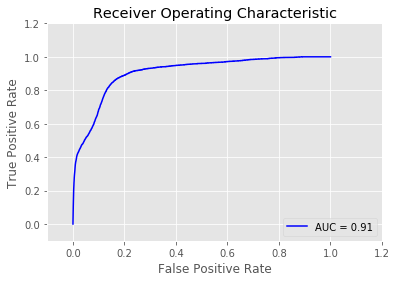

In [64]:
_,_,_ = atecml.data.accuracy_validation(val_df['Fraud'],foo[0])